In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
from tensorflow.keras import *
from google.colab import files
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import sigmoid, relu

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [0]:
tf.random.set_seed(115)

In [0]:
class DNet():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.input_shape = (self.img_rows, self.img_cols, self.channels)
        self.block = 4
        optimizer = optimizers.RMSprop(5e-2)
      
        self.model = self.build_model()
        self.model.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
        self.model.summary()
    def build_model(self, classes=10):
        def DenseBlock(x, channel):
          residual = x
          for i in range(self.block):
            x = ConvBlock(residual, channel)
            residual=layers.concatenate([x, residual])
          return x

        def ConvBlock(x, channel, dropoutrate=0.25):
          x = layers.Conv2D(channel, kernel_size=3, strides=1, padding='same', kernel_initializer=initializers.he_normal(115))(x)
          x = layers.SpatialDropout2D(dropoutrate)(x)
          x = BatchNormalization(axis=-1)(x)
          x = layers.Activation('elu')(x)
          return x 

        def downsample(x, channel):
          x = layers.Conv2D(channel, kernel_size=3, strides=2, padding='same', kernel_initializer=initializers.he_normal())(x)
          x = layers.SpatialDropout2D(0.25)(x)
          x = BatchNormalization(axis=-1)(x)
          x = layers.Activation('elu')(x)
          return x

        def build_layers(x, channel_list):
          for l in range(len(channel_list)):
            x = downsample(x, channel_list[l])
            x = DenseBlock(x, channel_list[l])
          return x
        channel_list = [32, 64]
        inpt = Input(shape=self.input_shape)
        x = build_layers(inpt, channel_list)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax')(x)
        return Model(inputs=inpt, outputs=x)

    def train(self, epoch, train_images, train_labels, batch_size=128):
        early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=2)
        history = self.model.fit(train_images, train_labels,
                                  batch_size=batch_size, 
                                  epochs=epoch, 
                                  verbose = 2,
                                  validation_split = (1/6),
                                  callbacks=[early_stop])
        return history
    def evaluate(self, test_images, test_labels, batch_size, verbose=2):
        test_loss, test_acc = self.model.evaluate(test_images, test_labels, batch_size=batch_size,verbose=2)
        return test_loss, test_acc

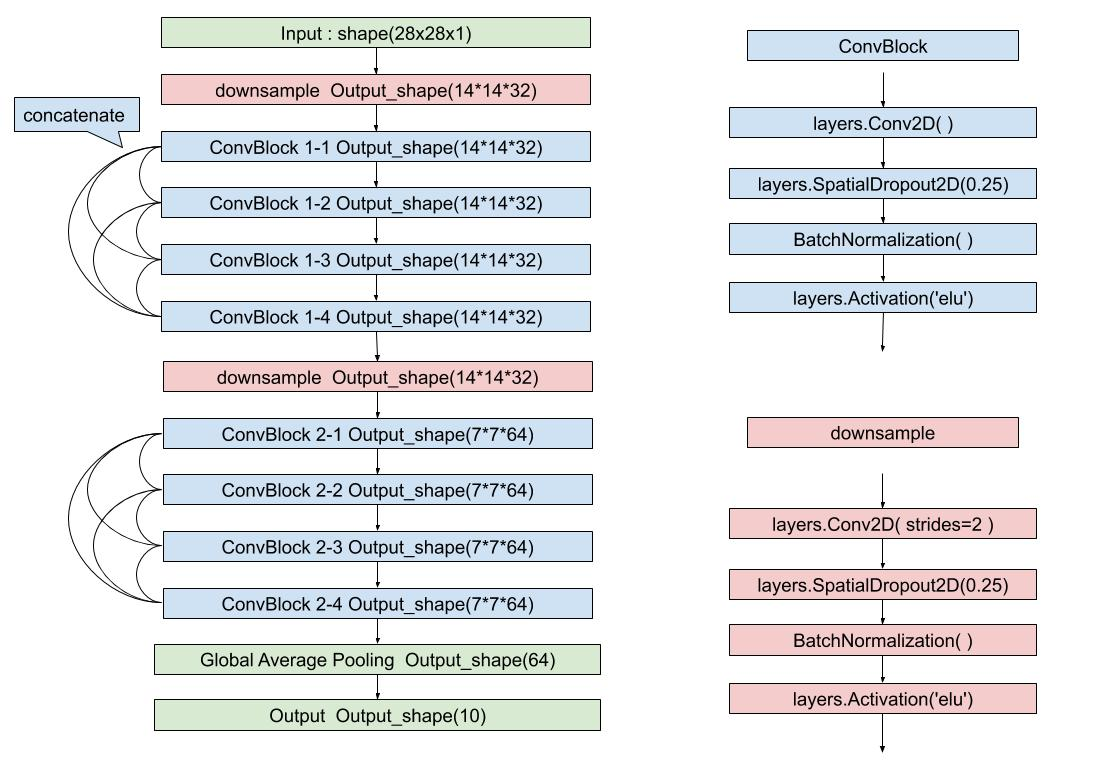

In [15]:
from IPython.display import Image
Image(filename = "Dnet.jpg" , width=850, height=600)   

In [6]:
net = DNet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 32)   128         spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [7]:
history = net.train(100, train_images, train_labels, 128)

Epoch 1/100
391/391 - 5s - loss: 0.9886 - accuracy: 0.6248 - val_loss: 0.8260 - val_accuracy: 0.7336
Epoch 2/100
391/391 - 5s - loss: 0.5891 - accuracy: 0.7833 - val_loss: 0.5559 - val_accuracy: 0.8195
Epoch 3/100
391/391 - 5s - loss: 0.4960 - accuracy: 0.8181 - val_loss: 0.3923 - val_accuracy: 0.8615
Epoch 4/100
391/391 - 5s - loss: 0.4459 - accuracy: 0.8366 - val_loss: 0.3720 - val_accuracy: 0.8695
Epoch 5/100
391/391 - 5s - loss: 0.4145 - accuracy: 0.8492 - val_loss: 0.4084 - val_accuracy: 0.8570
Epoch 6/100
391/391 - 5s - loss: 0.3916 - accuracy: 0.8581 - val_loss: 0.3595 - val_accuracy: 0.8773
Epoch 7/100
391/391 - 5s - loss: 0.3732 - accuracy: 0.8652 - val_loss: 0.3449 - val_accuracy: 0.8773
Epoch 8/100
391/391 - 5s - loss: 0.3579 - accuracy: 0.8717 - val_loss: 0.3352 - val_accuracy: 0.8892
Epoch 9/100
391/391 - 5s - loss: 0.3468 - accuracy: 0.8744 - val_loss: 0.3083 - val_accuracy: 0.8977
Epoch 10/100
391/391 - 5s - loss: 0.3325 - accuracy: 0.8811 - val_loss: 0.3981 - val_accura

In [8]:
test_loss, test_acc = net.evaluate(test_images, test_labels, batch_size=64, verbose=2)

157/157 - 0s - loss: 0.3021 - accuracy: 0.9239


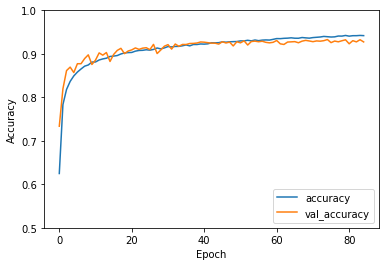

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

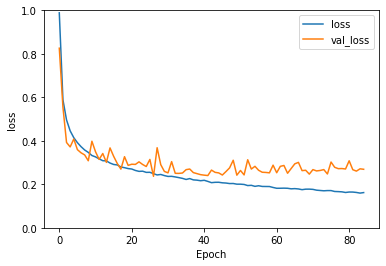

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')